In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Autograd import Value
from MLP import MLP
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')
# 确保支持中文显示（如果特征名或标签名中有中文）
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 设置随机种子以确保结果可重复
np.random.seed(1337)
random.seed(1337)


In [21]:
def softmax(outputs):
    """
    对输出层的值应用 Softmax 函数。
    输入：List[Value]
    输出：List[Value]，对应每个类别的概率
    """
    max_val = max(out.data for out in outputs)
    exps = [ (out - Value(max_val)).exp() for out in outputs ]
    sum_exps = sum(exps)
    probs = [exp_val / sum_exps for exp_val in exps]
    return probs

In [22]:
def cross_entropy_loss(probs, target_class):
    """
    计算交叉熵损失。
    输入：
        probs: List[Value]，每个类别的概率
        target_class: int，真实类别索引
    输出：
        loss: Value，交叉熵损失
    """
    # 获取正确类别的概率
    target_prob = probs[target_class]
    # 交叉熵损失： -log(p)
    loss = (-target_prob.log())
    return loss

In [23]:
# 加载数据
iris = load_iris()
X = iris.data  # 特征
y = iris.target  # 标签（0,1,2）

# 标准化特征
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
# 将训练集转换为 Value 对象
def create_batches(X, y, batch_size):
    """创建小批量数据"""
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start in range(0, len(X), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        X_batch = [list(map(Value, x)) for x in X[batch_indices]]
        y_batch = y[batch_indices]
        yield X_batch, y_batch

In [25]:
# 初始化模型
input_size = X.shape[1]  # 4
hidden_layers = [16, 16]  # 两个隐藏层，每层16个神经元
output_size = 3  # 三个类别
model = MLP(input_size=input_size, layer_sizes=hidden_layers, output_size=output_size)

# 打印模型结构
print("\n模型结构:")
print(model.describe())


模型结构:
MLP Structure:
  Layer 1:
    Layer with 16 Neurons:
      Neuron 1:         ReLUNeuron:
          Weights: [0.2355, 0.0665, -0.2683, 0.1716]
          Bias: 0.0000
      Neuron 2:         ReLUNeuron:
          Weights: [-0.6686, 0.6487, -0.2326, 0.5792]
          Bias: 0.0000
      Neuron 3:         ReLUNeuron:
          Weights: [0.8435, -0.3847, 0.9845, -0.5901]
          Bias: 0.0000
      Neuron 4:         ReLUNeuron:
          Weights: [0.3126, 0.8246, -0.7814, 0.6409]
          Bias: 0.0000
      Neuron 5:         ReLUNeuron:
          Weights: [-0.2025, -0.8693, 0.3984, -0.3038]
          Bias: 0.0000
      Neuron 6:         ReLUNeuron:
          Weights: [-0.1928, 0.6032, 0.6001, 0.3275]
          Bias: 0.0000
      Neuron 7:         ReLUNeuron:
          Weights: [0.6650, 0.1889, -0.0781, 0.9151]
          Bias: 0.0000
      Neuron 8:         ReLUNeuron:
          Weights: [0.5914, -0.3725, 0.3811, 0.8302]
          Bias: 0.0000
      Neuron 9:         ReLUNeuron:
    

In [26]:
# 训练参数
learning_rate = 0.01
epochs = 40
batch_size = 16


In [27]:
def evaluate(model, X, y):
    """评估模型在给定数据上的准确率"""
    correct = 0
    total = len(X)
    for x, target in zip(X, y):
        inputs = list(map(Value, x))
        outputs = model(inputs)
        probs = softmax(outputs)
        predicted = np.argmax([p.data for p in probs])
        if predicted == target:
            correct += 1
    return correct / total

In [28]:
# 训练模型

loss_history = []
accuracy_history = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    num_batches = 0

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        model.zero_grad()
        batch_loss = 0
        for x, target in zip(X_batch, y_batch):
            outputs = model(x)  # List[Value]
            probs = softmax(outputs)  # List[Value]
            loss = cross_entropy_loss(probs, target)
            loss.backward()
            batch_loss += loss.data
            # 计算准确率
            predicted = np.argmax([p.data for p in probs])
            if predicted == target:
                epoch_acc += 1
        # 平均损失
        batch_loss /= len(y_batch)
        epoch_loss += batch_loss
        num_batches += 1

        # 更新参数
        for param in model.parameters():
            param.data -= learning_rate * param.grad
            # 梯度清零
            param.grad = 0

    # 记录平均损失和准确率
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / len(y_train)
    loss_history.append(avg_loss)
    accuracy_history.append(avg_acc)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {avg_acc:.4f}")


Epoch 1/40 - Loss: 1.2655 - Accuracy: 0.5833
Epoch 10/40 - Loss: 0.0886 - Accuracy: 0.9667
Epoch 20/40 - Loss: 0.0490 - Accuracy: 0.9833
Epoch 30/40 - Loss: 0.0533 - Accuracy: 0.9833
Epoch 40/40 - Loss: 0.0377 - Accuracy: 0.9833


In [29]:
# 评估在测试集上的表现
test_accuracy = evaluate(model, X_test, y_test)
print(f"\n测试集准确率: {test_accuracy:.4f}")


测试集准确率: 0.9667


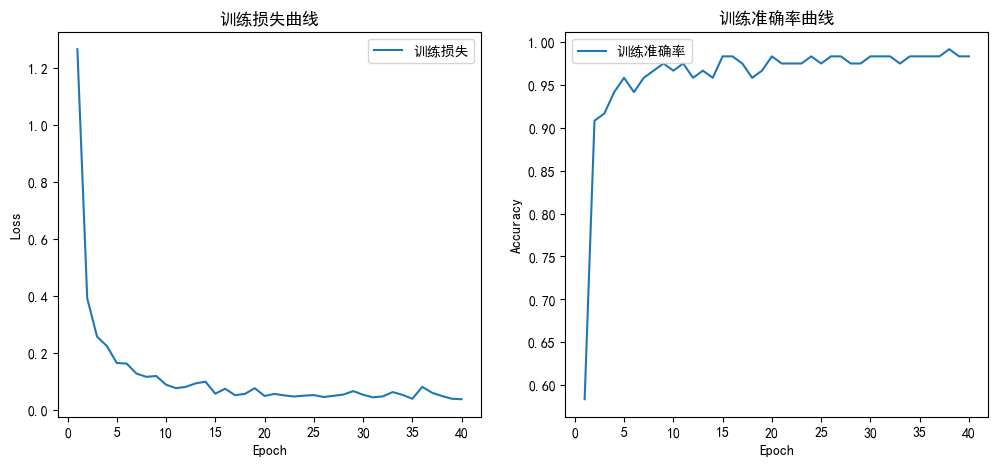

In [30]:
# 绘制训练过程

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), loss_history, label='训练损失')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练损失曲线')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), accuracy_history, label='训练准确率')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('训练准确率曲线')
plt.legend()

plt.show()